Parameter interpolation + forecasting

In [2]:
!pip install tensorflow==2.10.0

ERROR: Could not find a version that satisfies the requirement tensorflow==2.10.0 (from versions: 2.12.0rc0, 2.12.0rc1, 2.12.0, 2.12.1, 2.13.0rc0, 2.13.0rc1, 2.13.0rc2, 2.13.0, 2.13.1, 2.14.0rc0, 2.14.0rc1, 2.14.0, 2.14.1, 2.15.0rc0, 2.15.0rc1, 2.15.0, 2.15.0.post1, 2.15.1, 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0)
ERROR: No matching distribution found for tensorflow==2.10.0


In [3]:
# INSTALL IN COLAB IF NECESSARY
!pip install mat73
!pip install streamlit
!pip install keras-tuner
!pip install hdf5storage
!pip install pykrige

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 64.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 979.6/979.6 kB 35.4 MB/s eta 0:00:00


In [4]:
!python --version
import tensorflow as tf
print(tf.__version__)

Python 3.11.11
2.18.0


In [4]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
import sys
import os

lib_folder = '/content/drive/MyDrive/Colab_Notebooks/datasets'
sys.path.append(lib_folder)

In [6]:
import hosvd
import tfhosvd
import numpy as np
import time
import scipy.io
import mat73
import matplotlib.pyplot as plt
import tensorflow as tf
from pykrige.ok import OrdinaryKriging

In [7]:
### import tensorflow, keras, layers, optimizers, etc
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


Definition of functions

HOSVD auxiliary function

Define a tolerance (e.g 1E-3) and the number of retained modes will be selected automatically to fulfill this requirement

In [8]:

def perform_hosvd(tensor, tolerance):

    SNAP = tensor.shape[-1]

    TimePos = tensor.ndim-1

    Tensor0 = tensor.copy()
    shapeTens = list(np.shape(tensor))
    shapeTens[-1] = SNAP
    Tensor = np.zeros(shapeTens)

    Tensor[..., :] = Tensor0[..., 0:SNAP]

    nn0 = np.array(Tensor.shape)
    nn = np.array(nn0)
    nn[1:np.size(nn)] = 0

    return hosvd.HOSVD(Tensor, tolerance, nn, nn0, TimePos)

QR normalization

This should be performed to guarantee the orthonormalization.

In [9]:
def re_orthonormalize(tensor):
    Q,R = np.linalg.qr(tensor)
    return np.matmul(Q,R)


Kriging function.

In [10]:

def perform_kriging(feature_matrix, feature_labels, desired_feature):
    """ Perform kriging for each column in s_U to get interpolated values for a specific Reynolds number or AoA.
    Arguments:
    -feature matrix: The matrix or matrices that corresponds to the parameters the user wants to expand.
    -feature labels: Inside a list, the different Reynolds numbers and AoA that the user wants to get back.
    -desired_feature: The Reynolds number or Aoa the user wants to get.
     """
    interpolated_row = np.zeros((feature_matrix.shape[1],))

    for j in range(feature_matrix.shape[1]):
        column_data = feature_matrix[:, j]
        feature_flat = feature_labels
        Mode_flat = np.full_like(feature_flat, j)

        kriging_model = OrdinaryKriging(feature_flat, Mode_flat, column_data, variogram_model='exponential')

        interpolated_value, _ = kriging_model.execute('points', np.array([desired_feature]), np.array([j]))
        interpolated_row[j] = interpolated_value[0]
    print(f'Interpolated row for = {desired_feature}: {interpolated_row}')
    return interpolated_row


In [11]:
def perform_kriging_interpolation(m_matrix, re_labels, desired_re):
    """
    Perform kriging for each column in m_matrix to get interpolated values for a specific Reynolds number.

    Arguments:
    - m_matrix: The matrix containing data to be interpolated (e.g., POD modes).
    - re_labels: List of Reynolds numbers corresponding to rows of m_matrix.
    - desired_re: The Reynolds number at which interpolation is desired.

    Returns:
    - interpolated_row: A 1D array containing interpolated values for the specified Reynolds number.
    """
    interpolated_row = np.zeros((m_matrix.shape[1],))  # Number of modes

    for j in range(m_matrix.shape[1]):  # Iterate over columns (modes)
        column_data = m_matrix[:, j]  # Extract column data
        Re_flat = re_labels
        Mode_flat = np.full_like(Re_flat, j)  # Create mode labels

        # Create and fit the Kriging model
        kriging_model = OrdinaryKriging(Re_flat, Mode_flat, column_data, variogram_model='exponential')

        # Perform interpolation
        interpolated_value, _ = kriging_model.execute('points', np.array([desired_re]), np.array([j]))
        interpolated_row[j] = interpolated_value[0]  # Store the interpolated value

    print(f'Interpolated row for Reynolds number {desired_re}: {interpolated_row}')
    return interpolated_row

Rolling window function

In [12]:
def create_sequences(data, window_size, horizon):
  ''' Arguments:
  - data: Refers to the sequence of the temporal coefficients with the modes.
  - window_size: Refers to the length of the time sequence the user wants to use to train the model.
  - horizon: Refers to the number of temporal coefficients the user wants to predict over each sequence.
  '''
  X, y = [], []
  for i in range(len(data) - window_size - horizon + 1):
    X.append(data[i:i+window_size, :])  # Input window
    y.append(data[i+window_size:i+window_size+horizon, :])  # Output horizon

  return np.array(X), np.array(y)

Deep learning architecture for forecasting

In [13]:
def create_model(input_shape, output_shape): # arguments: input shape of the model, output shape of the model

    x = Input(shape= (*input_shape,))

    v = LSTM(256, return_sequences = False) (x)

    w = Dense(output_shape[0]*output_shape[1], activation = 'linear')(v)

    o = Reshape((output_shape[0],output_shape[1]))(w)

    model = Model(inputs=[x],
                  outputs=[o], name='Temporal_forecasting')
    model.compile(loss= 'mean_squared_error' , optimizer=Adam(learning_rate = 0.001 ), metrics=['mae'])

    return model

Main process.

Data loading and preprocessing.

Upload the tensor that is goingo to be expanded in means of Reynolds, Angle of Attack and Time. The user can select a study region on the tensor, in order to reduce the training time and avoid the use of irrelevant information during training.

In [22]:
tensor = np.load('/content/drive/MyDrive/Colab_Notebooks/datasets/tensor_7_128_250.npy')
#if you are working in local use the code commented below
#tensor = np.load('tensor_7_128_250.npy')
print(tensor.shape)

(4, 7, 128, 128, 250)


Apply HOSVD to the dataset.

HOSVD for four dimensions (n_comp, n_Re or AoA, n_X, n_Y, n_t)

In [23]:
varepsilon1 = 1e-3

print('\nPerforming HOSVD. Please wait...\n')
hatT, U, S, sv, nn1, n, TT = perform_hosvd(tensor, varepsilon1)


Performing HOSVD. Please wait...



2025-01-31 11:52:39.953 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 11:52:39.955 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 11:52:39.959 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 11:52:39.962 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 11:52:39.964 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 11:52:39.967 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 11:52:39.968 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-01-31 11:52:39.969 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

Worflow for different cases

In [24]:
U_copy = U.copy() #Make a copy of the mode matrices tensor in order to not change the original one.

The tensor must have the shape (n_comp, n_Re or n_AoA, n_X, n_Y, n_t)

For this tensor shape, parameter interpolation and forecasting can be performed.

In [25]:
######################## feature interpolation ###############################

feature_matrix = U_copy[0,1]
print(feature_matrix.shape)
#definition of labels for interpolation

feature_dim = feature_matrix.shape[0]

#feature_labels = [input('write the labels of the feature')]
feature_labels = [0, 0.5, 1.0,1.5, 2.0, 2.5, 3.0]

##desired re - must be implemented as an input
desired_feature = float(input('write the desidered feature'))

idx_below = np.searchsorted(feature_labels, desired_feature, side='right') - 1

feature_interpolated = perform_kriging_interpolation(feature_matrix, feature_labels, desired_feature)

upper_part = feature_matrix[:idx_below+1]
lower_part = feature_matrix[idx_below+1:]

feature_matrix = np.vstack((upper_part, feature_interpolated, lower_part))

U_copy[0,1] = feature_matrix

###############################forecasting################################
t_matrix = U_copy[0,4]
window_size = 41
horizon = 1

sequence, target = create_sequences(t_matrix, window_size, horizon)

#get the train, validation and test
split_idx_1 = int(0.7 * len(sequence))
split_idx_2 = int(0.85 * len(sequence))
seq_train, seq_val, seq_test = sequence[:split_idx_1], sequence[split_idx_1:split_idx_2], sequence[split_idx_2:]
tar_train, tar_val, tar_test = target[:split_idx_1], target[split_idx_1:split_idx_2], target[split_idx_2:]

in_shape = seq_train[0].shape
out_shape = [tar_train.shape[1],tar_train.shape[2]]

##compile the model
t_forecast = create_model(in_shape, out_shape)

##fit the model
t_fit  = t_forecast.fit(seq_train, tar_train, epochs = 40, batch_size = 8, validation_data = [seq_val, tar_val])

#perform predictions
t_forecast_pred = t_forecast.predict(seq_test)

### append to the dataset
t_new_matrix = np.concatenate((t_matrix, t_forecast_pred[-1,:,:]), axis=0)

U_copy[0,4] = t_new_matrix

new_tensor = hosvd.tprod(S, U_copy)



(7, 7)
write the desidered feature1.25
Interpolated row for Reynolds number 1.25: [ 3.78175504e-01 -3.66821521e-01  6.89916071e-02 -3.68455003e-01
  4.14059019e-05 -1.81359916e-05  1.98630501e-05]
Epoch 1/40


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_4']
Received: inputs=Tensor(shape=(None, 41, 25))
  warnings.warn(msg)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 90ms/step - loss: 0.0029 - mae: 0.0441 - val_loss: 0.0029 - val_mae: 0.0458
Epoch 2/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 0.0016 - mae: 0.0317 - val_loss: 0.0024 - val_mae: 0.0414
Epoch 3/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 9.4046e-04 - mae: 0.0227 - val_loss: 0.0019 - val_mae: 0.0375
Epoch 4/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - loss: 5.9333e-04 - mae: 0.0177 - val_loss: 0.0016 - val_mae: 0.0339
Epoch 5/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - loss: 3.4425e-04 - mae: 0.0133 - val_loss: 0.0013 - val_mae: 0.0301
Epoch 6/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 1.9561e-04 - mae: 0.0100 - val_loss: 0.0011 - val_mae: 0.0267
Epoch 7/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 1.1071e-04 - mae: 0.0077 - val_loss: 8.7027e-04 - val_mae: 0.0235
Epoch 8/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - loss: 7.2610e-05 - mae: 0.0063 - val_loss: 7.1029e-04 - val_mae: 0.0209
Epoch 9/40
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_4']
Received: inputs=Tensor(shape=(32, 41, 25))
  warnings.warn(msg)


In [20]:
plt.plot(new_tensor[0,idx_below+1,64,64,:], color = 'r', marker = 'x', label = 'predicted tensor')
plt.plot(tensor[0,idx_below+1,64,64,:], color = 'b', label = 'original tensor')
plt.title('Forecasting output')

Text(0.5, 1.0, 'Forecasting output')

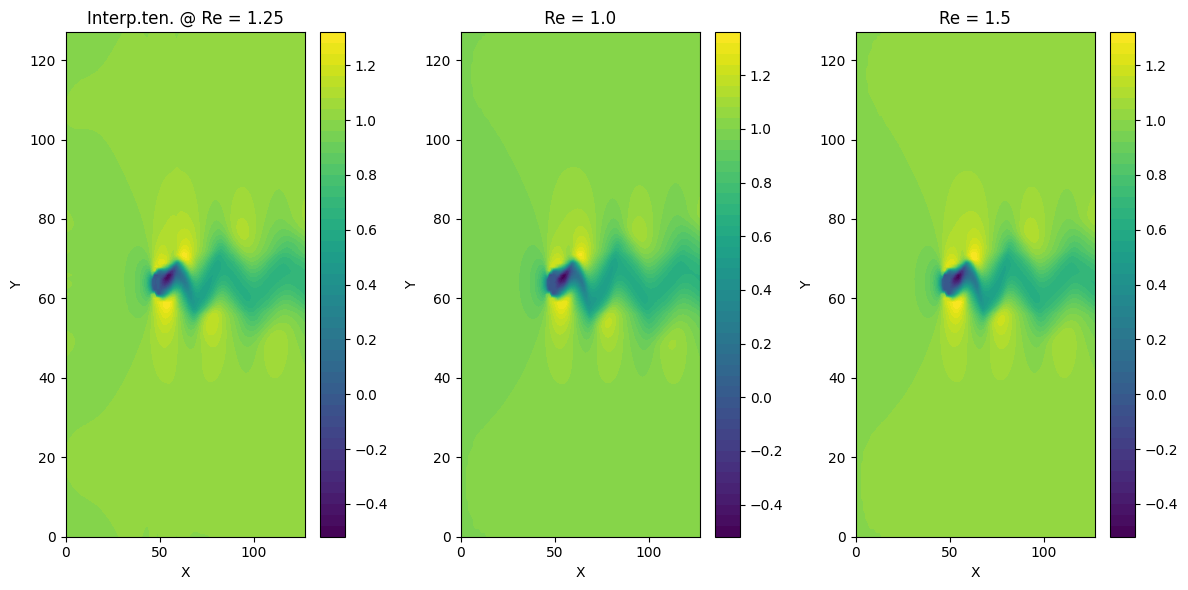

In [18]:
i = idx_below +1

# Contour plot for the streamwise velocity component

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

contour1 = ax[0].contourf(new_tensor[0, i, :, :, 0], levels = 50)
ax[0].set_title(f'Interp.ten. @ Re = {desired_feature}')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
plt.colorbar(contour1, ax=ax[0])

contour2 = ax[1].contourf(tensor[0, i, :, :, 0], levels =50)
ax[1].set_title(f' Re = {feature_labels[idx_below]} ')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
plt.colorbar(contour2, ax=ax[1])

contour3 = ax[2].contourf(tensor[0, i-1, :, :, 0], levels =50)
ax[2].set_title(f'Re = {feature_labels[idx_below+1]}')
ax[2].set_xlabel('X')
ax[2].set_ylabel('Y')
plt.colorbar(contour3, ax=ax[2])


plt.tight_layout()
plt.show()

# Contour plot for the normal velocity component

fig, ax = plt.subplots(1, 3, figsize=(12, 6))

contour1 = ax[0].contourf(new_tensor[1, i, :, :, 0], levels = 50)
ax[0].set_title(f'Interp.ten. @ Re = {desired_feature}')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
plt.colorbar(contour1, ax=ax[0])

contour2 = ax[1].contourf(tensor[1, i, :, :, 0], levels =50)
ax[1].set_title(f' Re = {feature_labels[idx_below]} ')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
plt.colorbar(contour2, ax=ax[1])

contour3 = ax[2].contourf(tensor[1, i-1, :, :, 0], levels =50)
ax[2].set_title(f'Re = {feature_labels[idx_below+1]}')
ax[2].set_xlabel('X')
ax[2].set_ylabel('Y')
plt.colorbar(contour3, ax=ax[2])


plt.tight_layout()
plt.show()

In [28]:
#### predict over time

# perform predictions
t_forecast_test = t_forecast.predict(seq_test[-1:,:,:])

num_iterations = 100
def predict_over_dataset(data, model, window_size, horizon, num_iterations):
    data = data.copy()
    new_matrix = np.zeros((num_iterations * horizon, data.shape[2]))
    idx = 0

    last_sequence = data[-1,:, :]

    for j in range(num_iterations):

        last_sequence_reshaped = last_sequence.reshape(1, window_size, data.shape[2])

        prediction = model.predict(last_sequence_reshaped)
        prediction = prediction.reshape(horizon, data.shape[2])

        new_matrix[idx:idx + horizon, :] = prediction
        idx += horizon

        last_sequence = np.concatenate([last_sequence[horizon:], prediction], axis=0)

    return new_matrix

over_matrix = predict_over_dataset(seq_test, t_forecast, window_size, horizon, num_iterations)

s_U = U.copy()
#over_matrix =over_matrix*range_t_matrix + max_t_matrix
s_U[0, 4] = np.concatenate((s_U[0, 4], over_matrix), axis=0)

A = hosvd.tprod(S, s_U)

plt.contourf(A[0,idx_below+1, :, :, -10])
plt.colorbar()
plt.title('Streamwise velocity - predicted tensor @ t = 340')
plt.show()

plt.contourf(A[1,idx_below+1, :, :, -10])
plt.colorbar()
plt.title('Normal velocity - predicted tensor @ t = 340')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━